In [ ]:
import keras
from keras import layers
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, f1_score
import tensorflow as tf
from sklearn.model_selection import train_test_split
import numpy as np

# Set random seeds for reproducibility
import random
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# Download and prepare dataset
vocab_size = 500  # Only consider the top 2k words
num_tokens_per_example = 200  # Only consider the first 200 words of each movie review
(x_train1, y_train1), (x_val1, y_val1) = keras.datasets.imdb.load_data(num_words=vocab_size)
# Concatenate the datasets
x_full = np.concatenate((x_train1, x_val1), axis=0)
y_full = np.concatenate((y_train1, y_val1), axis=0)

# Pad sequences
x_full = keras.utils.pad_sequences(x_full, maxlen=num_tokens_per_example)

# Split the data into train (60%), temp (40%) for validation and test
x_train, x_temp, y_train, y_temp = train_test_split(x_full, y_full, test_size=0.4, random_state=42)

# Split temp into validation (20%) and test (20%) of the original data
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=1/2, random_state=42)

# Define hyperparameters
embed_dim = 32  # Embedding size for each token.
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feedforward network.
num_experts = 2  # Number of experts used in the Switch Transformer.
batch_size = 50  # Batch size.
learning_rate = 0.01  # Learning rate.
dropout_rate = 0.5  # Dropout rate.
num_epochs = 20  # Number of epochs.
num_tokens_per_batch = batch_size * num_tokens_per_example  # Total number of tokens per batch.

# Implement token & position embedding layer
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

# Implement the feedforward network
def create_feedforward_network(ff_dim, embed_dim, name=None):
    return keras.Sequential(
        [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim)], name=name
    )

# Implement the load-balanced loss
def load_balanced_loss(router_probs, expert_mask):
    num_experts = tf.shape(expert_mask)[-1]
    density = tf.reduce_mean(expert_mask, axis=0)
    density_proxy = tf.reduce_mean(router_probs, axis=0)
    loss = tf.reduce_mean(density_proxy * density) * tf.cast((num_experts**2), "float32")
    return loss

# Implement the router as a layer
class Router(layers.Layer):
    def __init__(self, num_experts, expert_capacity):
        super().__init__()
        self.num_experts = num_experts
        self.expert_capacity = expert_capacity
        self.router_weights = self.add_weight(shape=(embed_dim, num_experts), initializer='random_normal', trainable=True)

    def call(self, inputs, attention_weights, training=False):
        # Step 1: Compute Router Logits and Probabilities
        router_logits = tf.matmul(inputs, self.router_weights)
        if training:
            router_logits += tf.random.uniform(
                shape=router_logits.shape, minval=0.9, maxval=1.1
            )
        router_probs = tf.nn.softmax(router_logits, axis=-1)

        # Step 2: Calculate Token Importance
        token_importance = tf.reduce_mean(attention_weights, axis=[1, 2])

        # Step 3: Determine the Number of Experts to Route Each Token
        num_experts_to_route = tf.cast(token_importance * self.num_experts, tf.int32)

        # Step 4: Select Top-k Experts for Each Token
        expert_gate, expert_index = tf.nn.top_k(router_probs, k=tf.reduce_max(num_experts_to_route))
        expert_index = tf.cast(expert_index, tf.int32)  # Ensure indices are integers
        expert_mask = tf.reduce_sum(tf.one_hot(expert_index, self.num_experts), axis=1)

        # Step 5: Create Expert Mask
        expert_mask = tf.reduce_sum(tf.one_hot(expert_index, self.num_experts), axis=1)

        # Step 6: Mask Tokens to Ensure Expert Capacity is Not Exceeded
        position_in_expert = tf.cumsum(expert_mask, axis=0) * expert_mask
        expert_mask *= tf.cast(tf.less(position_in_expert, self.expert_capacity), tf.float32)

        expert_mask_flat = tf.reduce_sum(expert_mask, axis=-1)
        expert_gate *= expert_mask_flat

        combined_tensor = tf.expand_dims(
            expert_gate * expert_mask_flat * tf.cast(tf.squeeze(tf.one_hot(expert_index, self.num_experts), 1), tf.float32),
            -1,
        ) * tf.cast(tf.squeeze(tf.one_hot(position_in_expert, self.expert_capacity), 1), tf.float32)

        dispatch_tensor = tf.cast(combined_tensor, "float32")
        return dispatch_tensor, combined_tensor

# Implement a Switch layer
class Switch(layers.Layer):
    def __init__(self, num_experts, embed_dim, ff_dim, num_tokens_per_batch, capacity_factor=1):
        super().__init__()
        self.num_experts = num_experts
        self.embed_dim = embed_dim
        self.experts = [
            create_feedforward_network(ff_dim, embed_dim) for _ in range(num_experts)
        ]

        self.expert_capacity = num_tokens_per_batch // self.num_experts
        self.router = Router(self.num_experts, self.expert_capacity)

    def call(self, inputs, attention_weights):
        batch_size = tf.shape(inputs)[0]
        num_tokens_per_example = tf.shape(inputs)[1]
        num_tokens_per_batch = batch_size * num_tokens_per_example
        inputs = tf.reshape(inputs, [num_tokens_per_batch, self.embed_dim])
        dispatch_tensor, combine_tensor = self.router(inputs, attention_weights)
        expert_inputs = tf.einsum("ab,acd->cdb", inputs, dispatch_tensor)
        expert_inputs = tf.reshape(
            expert_inputs, [self.num_experts, self.expert_capacity, self.embed_dim]
        )
        expert_input_list = tf.unstack(expert_inputs, axis=0)
        expert_output_list = [
            self.experts[idx](expert_input)
            for idx, expert_input in enumerate(expert_input_list)
        ]
        expert_outputs = tf.stack(expert_output_list, axis=1)
        expert_outputs_combined = tf.einsum(
            "abc,xba->xc", expert_outputs, combine_tensor
        )
        outputs = tf.reshape(
            expert_outputs_combined,
            [batch_size, num_tokens_per_example, self.embed_dim],
        )
        return outputs

from tensorflow.keras import layers

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions





# Implement the classifier
def create_classifier():
    ff_dim = 32  # Hidden layer size in feed forward network inside transformer
    switch = Switch(num_experts, embed_dim, ff_dim, num_tokens_per_batch)

    transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
    inputs = layers.Input(shape=(num_tokens_per_example,))
    embedding_layer = TokenAndPositionEmbedding(
        num_tokens_per_example, vocab_size, embed_dim
    )
    x = embedding_layer(inputs)
    x = transformer_block(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(ff_dim, activation="relu")(x)
    x = layers.Dropout(dropout_rate)(x)
    outputs = layers.Dense(2, activation="softmax")(x)
    classifier = keras.Model(inputs=inputs, outputs=outputs)
    return classifier



Epoch 1/20
600/600 [==============================] - 94s 153ms/step - loss: 0.6984 - accuracy: 0.5034 - val_loss: 0.6945 - val_accuracy: 0.4982
Epoch 2/20
600/600 [==============================] - 107s 178ms/step - loss: 0.6935 - accuracy: 0.5012 - val_loss: 0.6933 - val_accuracy: 0.4982
Epoch 3/20
600/600 [==============================] - 106s 176ms/step - loss: 0.6935 - accuracy: 0.5013 - val_loss: 0.6939 - val_accuracy: 0.4982
Epoch 4/20
600/600 [==============================] - 105s 175ms/step - loss: 0.6941 - accuracy: 0.4989 - val_loss: 0.6932 - val_accuracy: 0.5018
Epoch 5/20
600/600 [==============================] - 98s 163ms/step - loss: 0.6935 - accuracy: 0.4956 - val_loss: 0.6943 - val_accuracy: 0.4982
Epoch 6/20
600/600 [==============================] - 111s 185ms/step - loss: 0.6936 - accuracy: 0.4969 - val_loss: 0.6933 - val_accuracy: 0.4982
Epoch 7/20
313/313 [==============================] - 14s 44ms/step
Confusion Matrix:
 [[   0 4922]
 [   0 5078]]
Accuracy: 0.

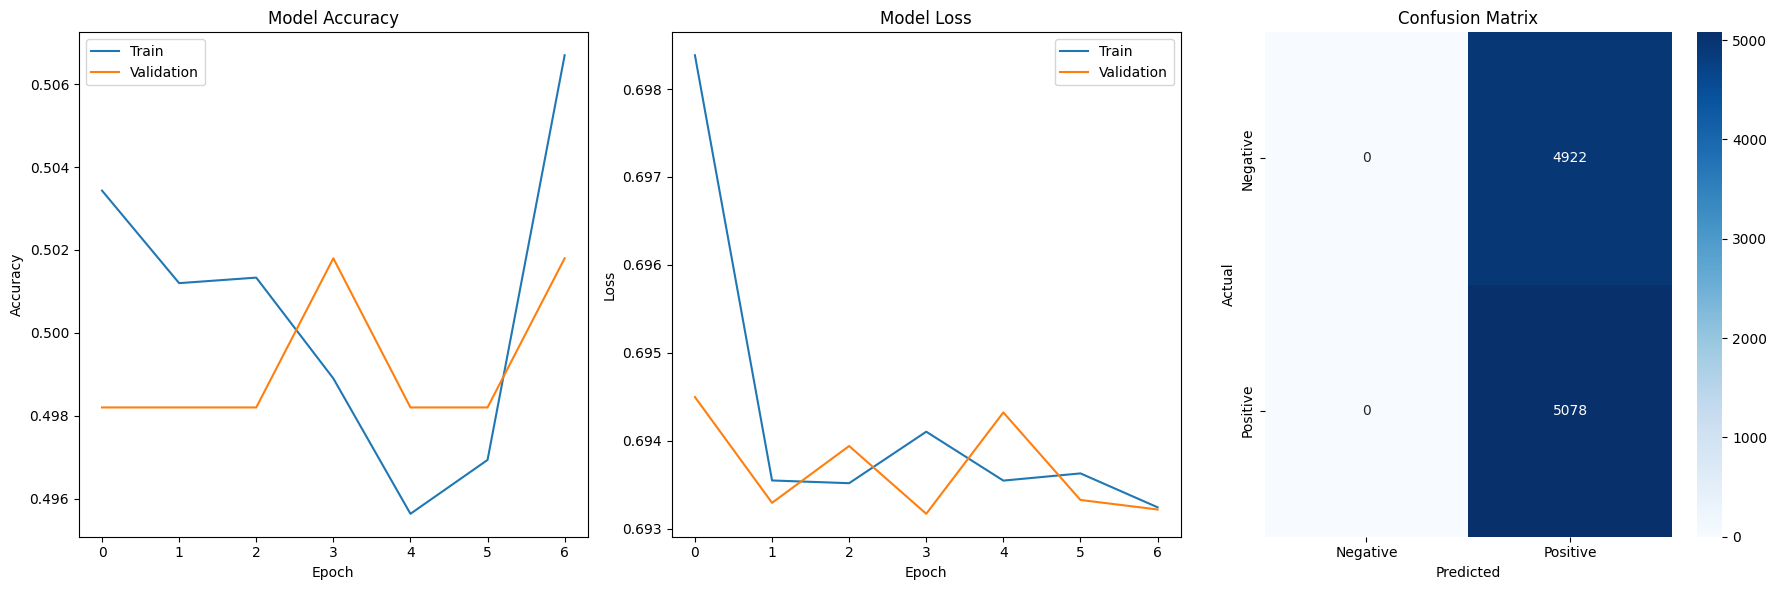

In [ ]:
# Run experiment with early stopping
def run_experiment_with_early_stopping(classifier):
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    classifier.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    history = classifier.fit(
        x_train,
        y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_data=(x_val, y_val),
        callbacks=[early_stopping],
    )
    return history

# Plot metrics
def plot_metrics(history, axes):
    # Plot accuracy
    axes[0].plot(history.history['accuracy'], label='Train')
    axes[0].plot(history.history['val_accuracy'], label='Validation')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_title('Model Accuracy')
    axes[0].legend()

    # Plot loss
    axes[1].plot(history.history['loss'], label='Train')
    axes[1].plot(history.history['val_loss'], label='Validation')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].set_title('Model Loss')
    axes[1].legend()

# Plot confusion matrix
def plot_confusion_matrix(cm, ax):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'], ax=ax)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_title('Confusion Matrix')

# Train the classifier with early stopping
classifier = create_classifier()
history = run_experiment_with_early_stopping(classifier)

# Create the subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot metrics
plot_metrics(history, axes)

# Predictions
y_pred = classifier.predict(x_test)
y_pred_classes = y_pred.argmax(axis=1)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Metrics
accuracy = accuracy_score(y_test, y_pred_classes)
sensitivity = recall_score(y_test, y_pred_classes, pos_label=1)
specificity = recall_score(y_test, y_pred_classes, pos_label=0)
f1 = f1_score(y_test, y_pred_classes)

print("Confusion Matrix:\n", cm)
print(f"Accuracy: {accuracy}")
print(f"Sensitivity: {sensitivity}")
print(f"Specificity: {specificity}")
print(f"F1 Score: {f1}")

# Plot confusion matrix
plot_confusion_matrix(cm, axes[2])

# Show the plots
plt.tight_layout()
plt.show()